# Demo code for a probabilistic solution to a Burger's equation with iterated EKS (i.e., the MAP estimate of the PDE)

(the code below is partially based on the code by Ming)


## The equation to be solved

Consider a scalar hyperbolic as the following
$$
u_t + (F(u))_x = 0, \quad (t, x) \in (0, T]\times(a, b)
$$
with the initial condition (IC) $u(0, x) = u_0(x)$ for $x \in [a, b]$ and Dirichlet boundary condition (DBC) $u(t, a) = u_a$ and $u(t, b) = u_b$ for $t \in [0, T]$.  

We consider solving the scalar hyperbolic PDE using a probabilistic PDE method which is a PDE extension of the method in [1]. The space and time grids are uniform
$$
\begin{aligned}
0 = t_0 < t_1 < \cdots < t_{N - 1} < t_L = T, & \\
a = x_0 < x_1 < \cdots < x_{J - 1} < x_J = b, &
\end{aligned}
$$
with $t_n - t_{n - 1} = \Delta t$ for $n = 1, \ldots, N$, and $x_j - x_{j - 1} = \Delta x$ for $j = 1, \ldots, J$. The solution is currently compared with Lax-Friedrich and Cole-Hopf methods.

[1] Filip Tronarp, Simo Särkkä, and Philipp Hennig (2021). Bayesian ODE Solvers: The Maximum A Posteriori Estimate Statistics and Computing 31, 23.  

In [ ]:
# get the necessary packages
import numpy as np
import scipy as sp
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermgauss

## Run Lax-Friedrich

In [ ]:
# define the Lax-Friedrich time advance
# we only advance the interior points, i.e. for x_1 to x_{N - 1}
def lax_friedrich_with_flux(u, dt, dx, F):
    u[1:-1] = (u[:-2] +u[2:])/2.0 -  dt*(F(u[2:])-F(u[:-2]))/(2.0*dx)
    return u[1:-1]

T = 1.5
a = -1.0
b = +1.0
# define the initial condition
u_0 = lambda x: -np.sin(np.pi * x)
# define the Dirichlet BC
u_a = u_b = 0.0
# define the Burgers' flux
Flux = lambda u: np.power(u, 2.0)/2.0
Flux_u = lambda u: u # Derivative w.r.t. u

def run_lf(dt, dx):

    # the number of spatial grid points
    J = int((b - a)/dx)
    # the number of temporal grid points
    N = int(T/dt)
    # construct the mesh in (t, x)
    x = np.linspace(a, b, J + 1)       # mesh points in space
    t = np.linspace(0, T, N + 1)       # mesh points in time

    u_LF = np.zeros((N + 1, J + 1))    # unknown u at new time level
    # Set initial condition
    for i in range(0, J + 1):
        u_LF[0, i] = u_0(x[i])
    # Lax-Friedrich
    for n in range(1, N + 1):
        u_LF[n, 1:-1] = lax_friedrich_with_flux(u_LF[n - 1, :], dt, dx, Flux)
        u_LF[n, 0] = u_a
        u_LF[n, -1] = u_b

    return t, x, u_LF


lf_dt = 0.001, lf_dx = 0.01


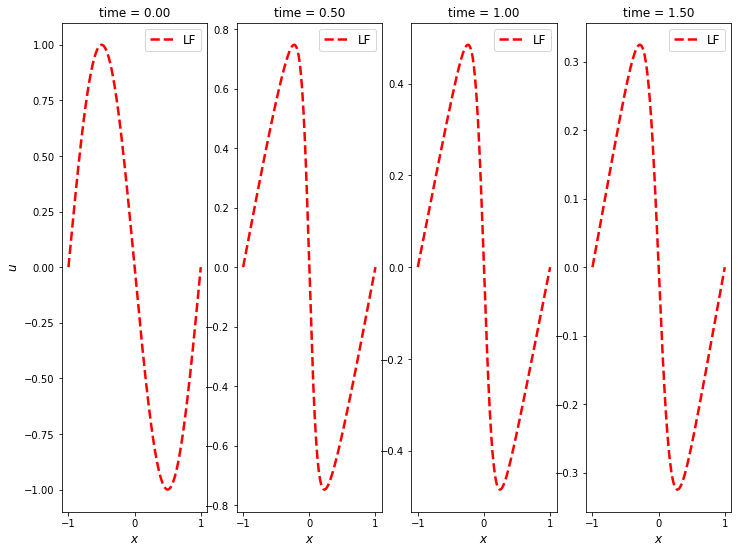

In [ ]:
# You can change these
lf_frames = [0, 500, 1000, 1500]
lf_dt = 0.001
lf_dx = 0.01

lf_t, lf_x, u_LF = run_lf(lf_dt, lf_dx)

print(f"lf_dt = {lf_dt}, lf_dx = {lf_dx}")

# choose the time (frame idx) at which the output is made
# show the side-by-side comparison at different times
fig = plt.figure(figsize = (12, 9))
for idx, frame_idx in enumerate(lf_frames):
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.plot(lf_x, u_LF[frame_idx, :], 'r--', linewidth = 2.5, label = 'LF')
    ax.set_xlabel('$x$', fontsize = 'large')
    if (idx == 0):
        ax.set_ylabel('$u$', fontsize = 'large')
    ax.set_title(r'time = {:.2f}'.format(lf_t[frame_idx]), fontsize = 'large')
    ax.legend(fontsize = 'large', loc = 'best')
plt.show()

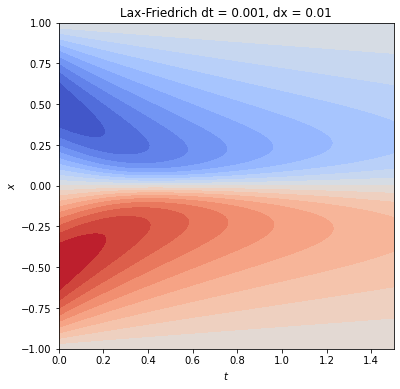

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(lf_t, lf_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contourf(Ts, Xs, u_LF.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title(f'Lax-Friedrich dt = {lf_dt}, dx = {lf_dx}')
plt.show()

## Run Cole-Hopf

In [ ]:
# Cole-Hopf transformation
qn = 128 # order of the quadarture
qx, qw = hermgauss(qn)  # points and weights
nu = 0.005/np.pi        # artificial viscosity
c2 = 2.0 * np.pi * nu
def Cole_Hopf(u, ti, xjs, num_x):
    c1 = 2.0 * np.sqrt(nu * ti)
    for xj_idx in range(num_x):
        top = -np.sum(c1 * qw * np.sin(np.pi * (xjs[xj_idx] - c1 * qx)) * np.exp(-np.cos(np.pi * (xjs[xj_idx] - c1 * qx))/c2))
        bot = np.sum(c1 * qw * np.exp(-np.cos(np.pi * (xjs[xj_idx] - c1 * qx))/c2))
        u[xj_idx] = top/bot
    return u

def run_ch(dt, dx):
    # the number of spatial grid points
    J = int((b - a)/dx)
    # the number of temporal grid points
    N = int(T/dt)
    # construct the mesh in (t, x)
    x = np.linspace(a, b, J + 1)       # mesh points in space
    t = np.linspace(0, T, N + 1)       # mesh points in time
    u_LF = np.zeros((N + 1, J + 1))    # unknown u at new time level for LF
    u_LW = np.zeros((N + 1, J + 1))    # unknown u at new time level for LW
    u_quad = np.zeros((N + 1, J + 1))  # unknown u at new time level for Cole-Hopf
    # Set initial condition
    u_quad[0, :] = u_0(x)
    # advance in time
    for n in range(1, N + 1):
        u_quad[n, :] = Cole_Hopf(u_quad[n, :], t[n], x, J + 1)

    return t, x, u_quad

ch_dt = 0.001, ch_dx = 0.01


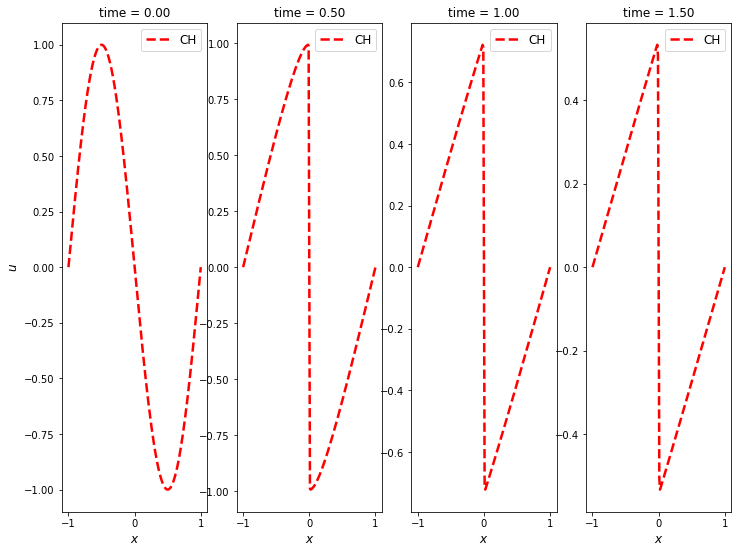

In [ ]:
# You can change these
ch_frames = [0, 500, 1000, 1500]
ch_dt = 0.001
ch_dx = 0.01

ch_t, ch_x, u_CH = run_ch(ch_dt, ch_dx)

print(f"ch_dt = {ch_dt}, ch_dx = {ch_dx}")

# choose the time (frame idx) at which the output is made
# show the side-by-side comparison at different times
fig = plt.figure(figsize = (12, 9))
for idx, frame_idx in enumerate(ch_frames):
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.plot(ch_x, u_CH[frame_idx, :], 'r--', linewidth = 2.5, label = 'CH')
    ax.set_xlabel('$x$', fontsize = 'large')
    if (idx == 0):
        ax.set_ylabel('$u$', fontsize = 'large')
    ax.set_title(r'time = {:.2f}'.format(ch_t[frame_idx]), fontsize = 'large')
    ax.legend(fontsize = 'large', loc = 'best')
plt.show()

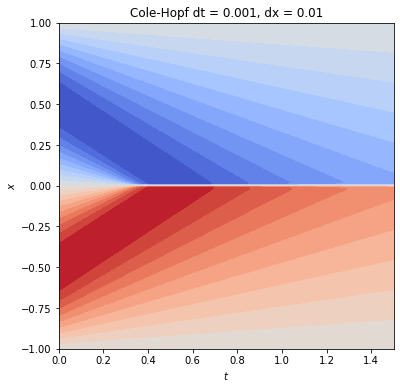

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ch_t, ch_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contourf(Ts, Xs, u_CH.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title(f'Cole-Hopf dt = {ch_dt}, dx = {ch_dx}')
plt.show()

## Run iterated EKS-based probabilistic solver

We can now do a symmetric space discretization for the PDE:
$$
\frac{du_j}{dt} + \frac{1}{2\Delta x}(F(u_{j+1}(t)) - F(u_{j-1}(t))) = 0,
$$
where $u_j(t) = u(t, x_j)$.

We now define the state as containing $\mathbf{x}(t) = [u_1, \ldots, u_{J-1}, du_1/dt, \ldots, du_{J-1}/dt]$. Then we can form form a Gaussian process prior whose temporal part is an integrated Wiener process and the spatial part has a SE/RBF covariance function as follows:
$$
  \mathbf{A} = \mathbf{A}_{\Delta t} \otimes \mathbf{I}_{J-1}, \\
  \mathbf{Q} = \mathbf{Q}_{\Delta t} \otimes \mathbf{C}_{J-1},
$$
where $A_{\Delta t}$ are the transition density parameters of (single) integrated Wiener process, and $\mathbf{C}_{J-1}$ is a matrix with elements $C_{J-1,ij} = \sigma^2 \, \exp(-(x_i - x_j)^2/(2\ell^2))$. Then the terms $u_j$ and $du_j/dt$ can be extracted with the matrices
$$
  \mathbf{H}_s = \begin{pmatrix} 1 & 0 \end{pmatrix} \otimes \mathbf{I}_{J-1}, \\
  \mathbf{H}_d = \begin{pmatrix} 0 & 1 \end{pmatrix} \otimes \mathbf{I}_{J-1}.
$$
Let us now define the function
$$
   f_j(\mathbf{x}) = \frac{1}{2\Delta x}(F(u_{j+1}(t)) - F(u_{j-1}(t)))
$$
then the pseudo-measurement model then takes the form
$$
  \mathbf{z}_n = \mathbf{H}_d \, \mathbf{x}(t_n) + \mathbf{f}(\mathbf{x}(t_n)) + \epsilon
$$
The required Jacobian of $\mathbf{g}(\mathbf{x}) = \mathbf{H}_d \, \mathbf{x} + \mathbf{f}(\mathbf{x})$ is given by
$$
  \mathbf{G}_x = \begin{pmatrix} \frac{1}{2\Delta x} \begin{pmatrix}
    0         & F_u(u_{2}) &            &            & & &  \\
    -F_u(u_1) & 0          & F_u(u_{3}) &            & & &  \\
              & -F_u(u_2)  & 0          & F_u(u_{4}) & & &  \\
              &            & -F_u(u_3)  & 0          & F_u(u_{5}) & &  \\
              &            &            & \ddots     & \ddots & \ddots & & \\
              &            &            & -F_u(u_{J-3})  & 0          & F_u(u_{J-1}) & \\
              &            &            &                & -F_u(u_{J-2})  &  \\
  \end{pmatrix} &
  \begin{pmatrix}
  1 & & \\
    & \ddots & \\
    & & 1
  \end{pmatrix}
  \end{pmatrix}
$$

## Run iterated EKS-based probabilistic solver

In [ ]:
def run_ieks(dt, dx, sig=10, nell=2, niter=10):
    # the number of spatial grid points
    J = int((b - a)/dx)
    # the number of temporal grid points
    N = int(T/dt)
    # construct the mesh in (t, x)
    x = np.linspace(a, b, J + 1)       # mesh points in space
    t = np.linspace(0, T, N + 1)       # mesh points in time

    ell = nell*dx

    A_dt = np.array([[1,dt],[0,1]])
    Q_dt = np.array([[dt**3/3,dt**2/2],[dt**2/2,dt]])

    I_Jm1 = np.eye(J-1)
    C_Jm1 = np.zeros((J-1,J-1))
    for i in range(0,J-1):
        for j in range(0,J-1):
            C_Jm1[i,j] = sig**2 * np.exp(-(x[i+1] - x[j+1])**2 / (2*ell**2))

    A = np.kron(A_dt,I_Jm1)
    Q = np.kron(Q_dt,C_Jm1)
    H_s = np.kron(np.array([[1,0]]),I_Jm1)
    H_d = np.kron(np.array([[0,1]]),I_Jm1)

    def g(x):
        u = x[:J-1]
        u_jp1 = np.concatenate( (u[1:], np.array([u_b])) )
        u_jm1 = np.concatenate( (np.array([u_a]), u[0:-1]) )
        f = (Flux(u_jp1) - Flux(u_jm1)) / (2.0 * dx)
        du = x[J-1:]
        return du + f

    def G_x(x):
        u = x[:J-1]
        G1 = sparse.diags((-Flux_u(u[0:-1]), Flux_u(u[1:])), (-1,1)).toarray() / (2.0 * dx)
        G2 = np.eye(J-1)
        return np.concatenate((G1,G2),axis=1)

    nominal = np.empty((N+1, 2 * (J-1)))

    for iter in range(niter):
        # Initialize
        m = np.zeros(2 * (J-1))
        for i in range(0, J-1):
            m[i] = u_0(x[i+1])
            m[i+J-1] = 0

        P = linalg.block_diag( np.zeros((J-1,J-1)), np.eye(J-1) )

        m_list = np.empty((N+1, 2 * (J-1)))
        P_list = np.empty((N+1, 2 * (J-1), 2 * (J-1)))

        m_list[0,:] = m
        P_list[0,:,:] = P

        err = 0

        for n in range(1, N + 1):
            m = A @ m
            P = A @ P @ A.T + Q

            if iter == 0:
                mn = m
            else:
                mn = nominal[n,:]
            G_val = G_x(mn)
            g_val = g(mn) + G_val @ (m - mn)

            S = G_val @ P @ G_val.T
            K = linalg.solve(S, G_val @ P).T

            m = m + K @ (-g_val)

            err = err + np.dot(g_val,g_val)

            B = np.eye(K.shape[0]) - K @ G_val
            P = B @ P @ B.T

            m_list[n,:] = m
            P_list[n,:,:] = P

        err = err / dx / N / J
        print(f"err = {err}")

        ms_list = m_list.copy()
        Ps_list = P_list.copy()
        ms = m_list[-1,:]
        Ps = P_list[-1,:,:]

        u_PS = np.zeros((N + 1, J + 1))
        u_PS_var = np.zeros((N + 1, J + 1))

        u_PS[n,0] = u_a
        u_PS[n,-1] = u_b
        u_PS[n,1:-1] = H_s @ m

        for n in range(N,-1,-1):
            m = m_list[n,:]
            P = P_list[n,:,:]

            mp = A @ m
            Pp = A @ P @ A.T + Q

            Gk = linalg.solve(Pp, A @ P).T
            ms = m + Gk @ (ms - mp)
            Ps = P + Gk @ (Ps - Pp) @ Gk.T

            ms_list[n,:] = ms
            Ps_list[n,:,:] = Ps

            u_PS[n,0] = u_a
            u_PS[n,-1] = u_b
            u_PS[n,1:-1] = H_s @ ms

            u_PS_var[n,0] = 0
            u_PS_var[n,-1] = 0
            u_PS_var[n,1:-1] = np.diag(H_s @ Ps @ H_s.T)

        if iter == 0:
            nominal = ms_list.copy()
        else:
            c = 0.1
            nominal = (1 - c) * nominal + c * ms_list

    return t, x, u_PS, u_PS_var



err = 14.906022476981068
err = 7.798663454033289
err = 7.663510759673264
err = 7.5968823291616
err = 7.573430745834471
err = 7.5689037218648005
err = 7.570889956291324
err = 7.575389018662827
err = 7.581341792205182
err = 7.5882274316287
dt = 0.05, dx = 0.02


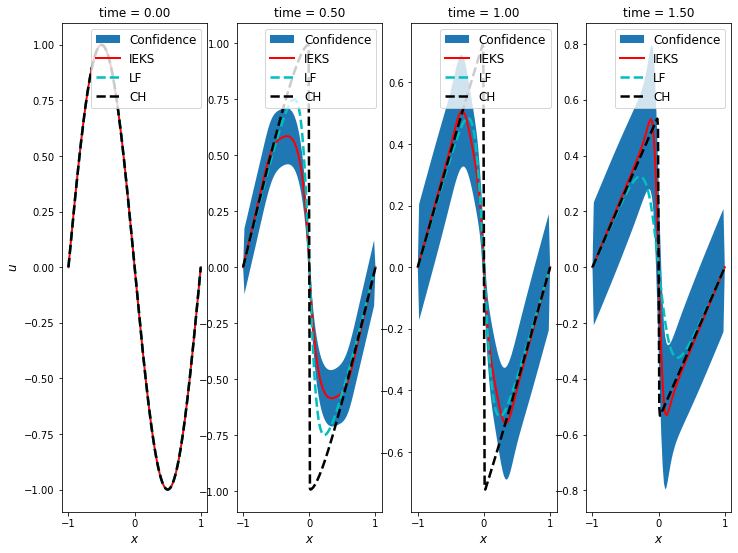

In [ ]:
# Run with a quite rough grid

#ps_frames = [0, 500, 1000, 1500]
#ps_dt = 0.001

#ps_frames = [0, 50, 100, 150]
#ps_dt = 0.01

ps_frames = [0, 10, 20, 30]
ps_dt = 0.05

ps_dx = 0.02

ps_t, ps_x, u_PS, u_PS_var = run_ieks(ps_dt, ps_dx, 10, 2)

print(f"dt = {ps_dt}, dx = {ps_dx}")

# choose the time (frame idx) at which the output is made
# show the side-by-side comparison at different times
fig = plt.figure(figsize = (12, 9))
for idx, frame_idx in enumerate(ps_frames):
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.fill_between(ps_x, u_PS[frame_idx, :] - 1.96 * np.sqrt(u_PS_var[frame_idx, :]), u_PS[frame_idx, :] + 1.96 * np.sqrt(u_PS_var[frame_idx, :]), label = 'Confidence')
    ax.plot(ps_x, u_PS[frame_idx, :], 'r-', linewidth = 2.0, label = 'IEKS')
    ax.plot(lf_x, u_LF[lf_frames[idx], :], 'c--', linewidth = 2.5, label = 'LF')
    ax.plot(ch_x, u_CH[ch_frames[idx], :], 'k--', linewidth = 2.5, label = 'CH')
    ax.set_xlabel('$x$', fontsize = 'large')
    if (idx == 0):
        ax.set_ylabel('$u$', fontsize = 'large')
    ax.set_title(r'time = {:.2f}'.format(ps_t[frame_idx]), fontsize = 'large')
    ax.legend(fontsize = 'large', loc = 'upper right')
plt.show()

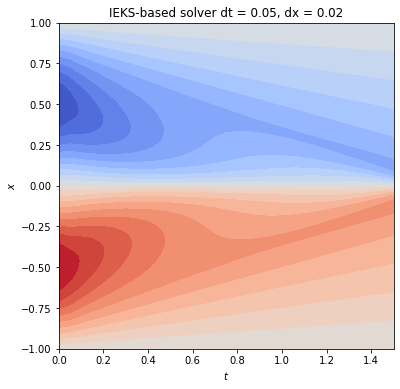

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ps_t, ps_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contourf(Ts, Xs, u_PS.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title(f'IEKS-based solver dt = {ps_dt}, dx = {ps_dx}')
plt.show()

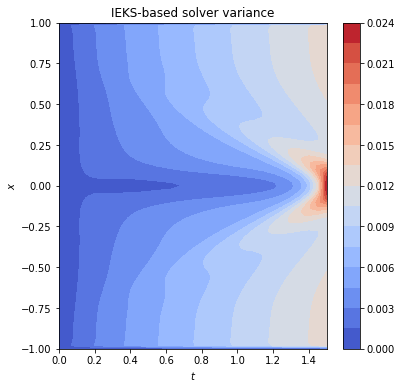

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ps_t, ps_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
im = ax.contourf(Ts, Xs, u_PS_var.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('IEKS-based solver variance')
fig.colorbar(im, orientation='vertical')
plt.show()

## IEKS solver with denser grid

err = 4.837367892533234
err = 2.462867560405614
err = 2.407451152855974
err = 2.348108111504707
err = 2.2892674154455857
err = 2.2336842935352594
err = 2.1826323130899663
err = 2.136463004933129
err = 2.0950764070123418
err = 2.058189583952044
dt = 0.01, dx = 0.01


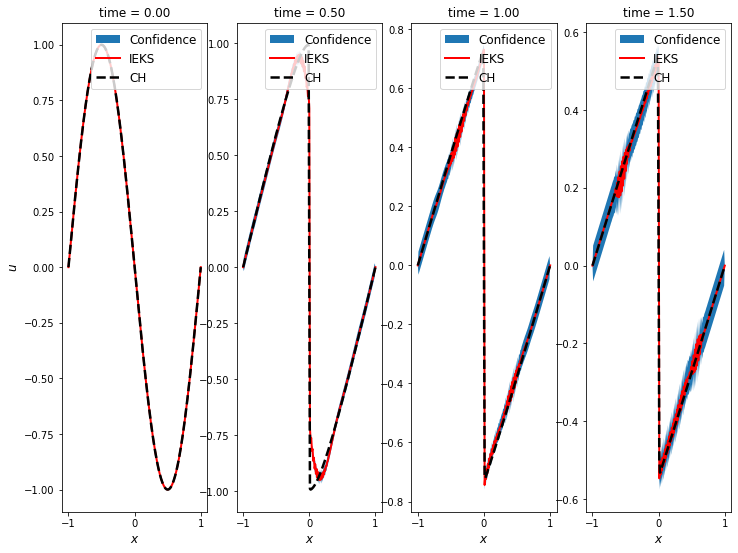

In [ ]:
# Run with a quite rough grid

#ps_frames = [0, 500, 1000, 1500]
#ps_dt = 0.001

ps_frames = [0, 50, 100, 150]
ps_dt = 0.01

#ps_frames = [0, 10, 20, 30]
#ps_dt = 0.05

ps_dx = 0.01

ps_t, ps_x, u_PS, u_PS_var = run_ieks(ps_dt, ps_dx, 10, 1.5)

print(f"dt = {ps_dt}, dx = {ps_dx}")

# choose the time (frame idx) at which the output is made
# show the side-by-side comparison at different times
fig = plt.figure(figsize = (12, 9))
for idx, frame_idx in enumerate(ps_frames):
    ax = fig.add_subplot(1, 4, idx + 1)
    ax.fill_between(ps_x, u_PS[frame_idx, :] - 1.96 * np.sqrt(u_PS_var[frame_idx, :]), u_PS[frame_idx, :] + 1.96 * np.sqrt(u_PS_var[frame_idx, :]), label = 'Confidence')
    ax.plot(ps_x, u_PS[frame_idx, :], 'r-', linewidth = 2.0, label = 'IEKS')
    ax.plot(ch_x, u_CH[ch_frames[idx], :], 'k--', linewidth = 2.5, label = 'CH')
    ax.set_xlabel('$x$', fontsize = 'large')
    if (idx == 0):
        ax.set_ylabel('$u$', fontsize = 'large')
    ax.set_title(r'time = {:.2f}'.format(ps_t[frame_idx]), fontsize = 'large')
    ax.legend(fontsize = 'large', loc = 'upper right')
plt.show()

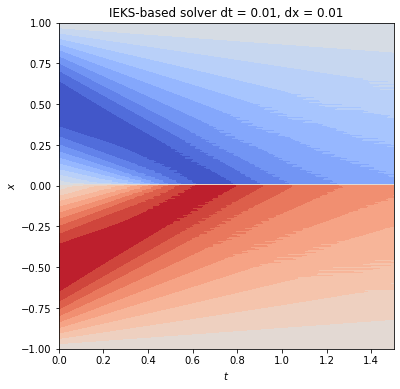

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ps_t, ps_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contourf(Ts, Xs, u_PS.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title(f'IEKS-based solver dt = {ps_dt}, dx = {ps_dx}')
plt.show()

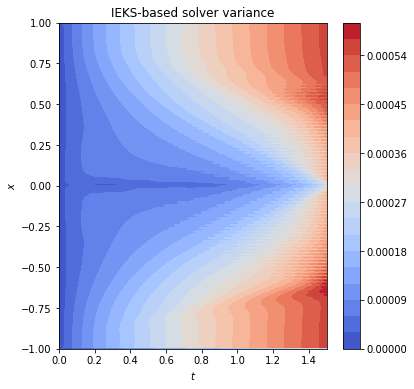

In [ ]:
import matplotlib.ticker as ticker
Ts, Xs = np.meshgrid(ps_t, ps_x)
# plot the PINN solution and comparison at x = 0 and x = 1
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_powerlimits((0, 0))
num_cLines = 20
# use contourf to fill in the color
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
im = ax.contourf(Ts, Xs, u_PS_var.T, num_cLines, cmap = plt.cm.coolwarm)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('IEKS-based solver variance')
fig.colorbar(im, orientation='vertical')
plt.show()